In [2]:
import os
import re
import dotenv
import numpy as np
import pandas as pd
from pprint import pprint

import catboost as cb

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [28]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [9]:
X = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/X_catboost.csv', encoding='utf-8')
y = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_both.csv', encoding='utf-8')

In [10]:
X = X.set_index('ID')
y = y.set_index('ID')

In [24]:
X['topic_lda'] = X.topic_lda.astype(str)
X['bert_keywords'] = X.bert_keywords.fillna('')
X['hashtags'] = X.hashtags.fillna('')
X['timestamp_posted'] = pd.to_datetime(X['timestamp_posted'])

In [5]:
# X = df.loc[:, ["post_id", "log_init_imps", "log_init_engs", "Dominant_Topic", "Keywords"]]
# X = X.set_index('post_id')
# X['Keywords'] = X['Keywords'].apply(lambda x: x[1:] if x.startswith(',') else x)#.str.split(',')
# X['Dominant_Topic'] = X['Dominant_Topic'].astype(int) 

# cat_features = ['Keywords', 'Dominant_Topic']

# y = df.loc[:, ["post_id", "log_all_engrate"]]
# y = y.set_index('post_id')
# y = y.squeeze()
# print(X.head())
# print(y.head())

                                                    log_init_imps  \
post_id                                                             
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       8.836810   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...      10.852304   
149644004573512a361a5d89ab8c9003080a3af20fca364...       9.495219   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       8.348538   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04f546d...       7.942007   

                                                    log_init_engs  \
post_id                                                             
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       5.420535   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...       8.478660   
149644004573512a361a5d89ab8c9003080a3af20fca364...       5.988961   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       6.570883   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04f546d...       4.077537   

                                

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['fanpage_id'])

In [26]:
X_train = X_train.drop(columns=['fanpage_id'])
X_test = X_test.drop(columns=['fanpage_id'])
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [27]:
cat_features = ['hashtags', 'bert_keywords', 'topic_lda']

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4168 entries, urn:li:share:7015109880122384384 to urn:li:ugcPost:7091797022185295873
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   has_any_image          4168 non-null   bool          
 1   hashtags               4168 non-null   object        
 2   has_any_hashtag        4168 non-null   bool          
 3   hour_posted            4168 non-null   int64         
 4   day_posted             4168 non-null   int64         
 5   fanpage_id             4168 non-null   float64       
 6   timestamp_posted       4168 non-null   datetime64[ns]
 7   length_text_posted     4168 non-null   int64         
 8   topic_lda              4168 non-null   object        
 9   sure_belongs_to_topic  4168 non-null   float64       
 10  week_posted            4168 non-null   int64         
 11  minute_posted          4168 non-null   int64         
 12  bert_k

In [29]:
catboost_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    logging_level='Silent'
)

grid = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.03, 0.07, 0.1, 0.15, 0.2],
    'depth': [2, 4, 6, 8]
}

# Define the scoring metric for the grid search
scorer = make_scorer(r2_score)

grid_search = GridSearchCV(
    catboost_model,
    grid,
    scoring=scorer,
    cv = 10
)

# Perform the grid search
grid_search.fit(X_train, y_train, cat_features=cat_features)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [30]:
print(best_params)

{'depth': 2, 'iterations': 100, 'learning_rate': 0.07}


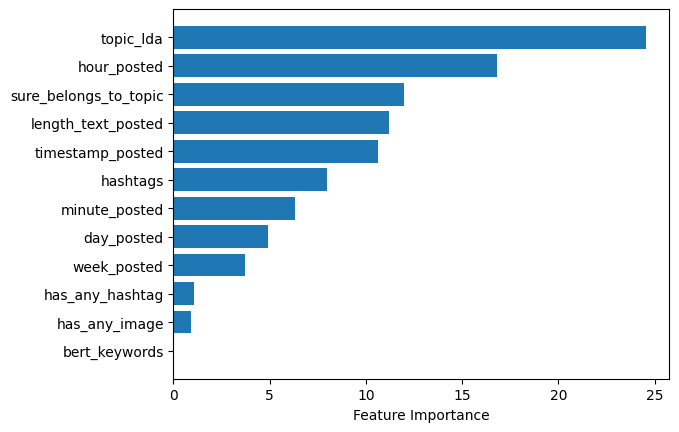

In [31]:
feature_importance = best_model.get_feature_importance(type=cb.EFstrType.FeatureImportance)
feature_names = X_train.columns

# Create a sorted index based on feature importance
sorted_idx = feature_importance.argsort()

# Plot feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [32]:
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Train R-squared: {train_score:.2f}")
print(f"Test R-squared: {test_score:.2f}")

Train R-squared: 0.05
Test R-squared: 0.01


In [34]:
# get train/test predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

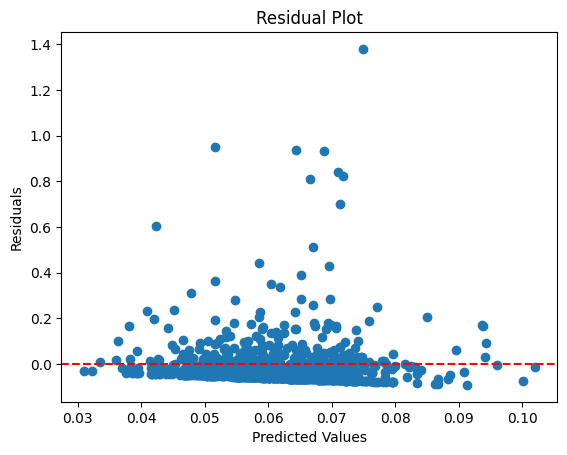

In [35]:
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

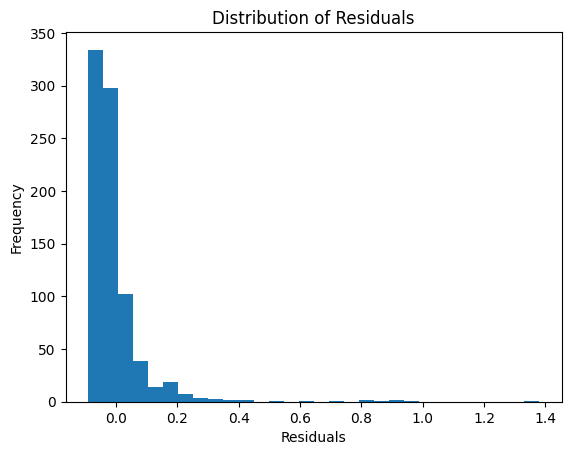

In [36]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

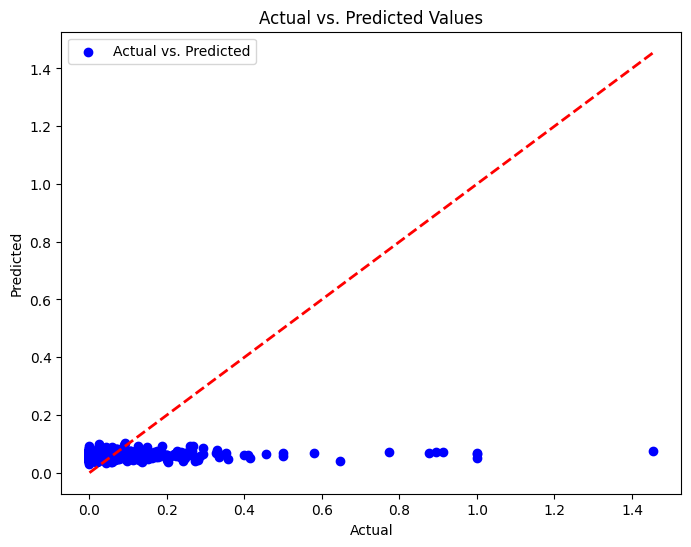

In [37]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [30]:
# Save the model
best_model.save_model(os.path.join('TRAINED_MODELS_PATH', 'catboost_model.bin'))